In [1]:
from data_loader import read_json_as_df

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV

pd.options.display.max_colwidth = 1000

In [2]:
train_df = read_json_as_df('combined-train.json')
test_df = read_json_as_df('combined-test.json')

Mean: 431.3398733199444 
Median: 212.0 
Std: 634.5942912261138 


{'whiskers': [<matplotlib.lines.Line2D at 0x29ba4077588>,
 'caps': [<matplotlib.lines.Line2D at 0x29ba4077cc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x29ba4077438>],
 'medians': [<matplotlib.lines.Line2D at 0x29ba408c400>],
 'fliers': [<matplotlib.lines.Line2D at 0x29ba408c780>],
 'means': []}

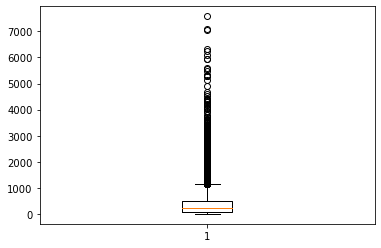

In [3]:
text_lengths = np.array([len(sent) for sent in train_df.text])

print(f'Mean: {np.mean(text_lengths)} \nMedian: {np.median(text_lengths)} \nStd: {np.std(text_lengths)} ')

plt.boxplot(text_lengths)

Mean: 552.390977443609 
Median: 339.0 
Std: 612.6174318555834 


{'whiskers': [<matplotlib.lines.Line2D at 0x29ba6123cf8>,
 'caps': [<matplotlib.lines.Line2D at 0x29ba6130438>,
 'boxes': [<matplotlib.lines.Line2D at 0x29ba6123ba8>],
 'medians': [<matplotlib.lines.Line2D at 0x29ba6130b38>],
 'fliers': [<matplotlib.lines.Line2D at 0x29ba6130ef0>],
 'means': []}

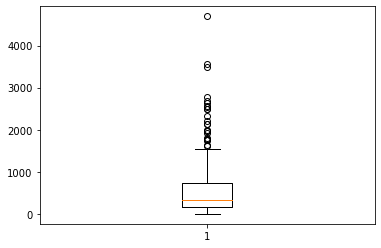

In [4]:
text_lengths = np.array([len(sent) for sent in test_df.text])

print(f'Mean: {np.mean(text_lengths)} \nMedian: {np.median(text_lengths)} \nStd: {np.std(text_lengths)} ')

plt.boxplot(text_lengths)

In [5]:
train_df.priority.value_counts()

green       3979
amber       1581
red          651
escalate     262
Name: priority, dtype: int64

In [6]:
test_df.priority.value_counts()

green       159
amber       154
red          69
escalate     17
Name: priority, dtype: int64

In [7]:
vectorizer = TfidfVectorizer(ngram_range=(1,1))

# Initial model creation without using test set

In [8]:
features = vectorizer.fit_transform(train_df.text)
test_features = vectorizer.transform(test_df.text)

In [9]:
features.shape

(6473, 16017)

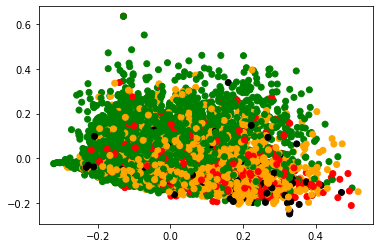

In [10]:
dense_features = features.todense()

pca = PCA(n_components=2).fit(dense_features)

features_2d = pca.transform(dense_features)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=train_df.priority.map({'green': 'green', 
                                                                           'amber': 'orange',
                                                                           'red': 'red',
                                                                           'escalate': 'black'}))

In [11]:
%%time

params = {'C': scipy.stats.expon(scale=10), 'gamma': scipy.stats.expon(scale=.1), 'kernel': ['rbf'], 'class_weight':['balanced']}

# clf = RandomizedSearchCV(estimator=SVC(),
#                          param_distributions=params,
#                          n_jobs=-1,
#                          scoring='f1_macro',
#                          cv=5,
#                          n_iter=100)

clf = SVC(C=4.884011448032894, break_ties=False, cache_size=200,
    class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.11307298207551204, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False) 

searched_clf = clf.fit(features, train_df.priority)

# print('Best Params:', searched_clf.best_params_, '\n')
# print('Best macro avg F1 score:', searched_clf.best_score_, '\n')
# print(searched_clf.best_estimator_, '\n')



Wall time: 14 s


# Main method to test classifier

In [12]:
def run_tfidf_svc(clf, xtest, ytest):
    
    predicted_priority = clf.predict(xtest)

    print('Classification Report:\n', classification_report(ytest, predicted_priority))
    
    return predicted_priority
    
    

# Train and test on full datasets

In [14]:
predicted_priority = run_tfidf_svc(clf = searched_clf,
                                   xtest = test_features,
                                   ytest = test_df.priority)

Classification Report:
               precision    recall  f1-score   support

       amber       0.65      0.58      0.62       154
    escalate       0.44      0.47      0.46        17
       green       0.71      0.88      0.79       159
         red       0.60      0.41      0.48        69

    accuracy                           0.67       399
   macro avg       0.60      0.59      0.59       399
weighted avg       0.66      0.67      0.66       399



## Official - ignoring 'green' priority

In [15]:
print('Macro avgd f1 score: ',
      f1_score(test_df.priority,
               predicted_priority, 
               labels=['escalate', 'red', 'amber'],
               average='macro'))

Macro avgd f1 score:  0.5187799446656319


## Flagged - 'crisis + red + amber' as flagged vs 'green'

In [16]:
def map_flagged(label):
    if label in ['escalate', 'red', 'amber']:
        return 'flagged'
    elif label == 'green':
        return 'green'

flagged_ytest = list(map(map_flagged, test_df.priority))
flagged_predictions = list(map(map_flagged, predicted_priority))

print('Classification Report:\n', classification_report(flagged_ytest, flagged_predictions))

Classification Report:
               precision    recall  f1-score   support

     flagged       0.91      0.77      0.83       240
       green       0.71      0.88      0.79       159

    accuracy                           0.81       399
   macro avg       0.81      0.82      0.81       399
weighted avg       0.83      0.81      0.81       399



## Urgent - 'red + escalate' as urgent vs 'amber + green' as non_urgent

In [17]:
def map_urgent(label):
    if label in ['escalate', 'red']:
        return 'urgent'
    elif label in ['green', 'amber']:
        return 'non-urgent'

urgent_ytest = list(map(map_urgent, test_df.priority))
urgent_predictions = list(map(map_urgent, predicted_priority))

print('Classification Report:\n', classification_report(urgent_ytest, urgent_predictions))

Classification Report:
               precision    recall  f1-score   support

  non-urgent       0.88      0.94      0.91       313
      urgent       0.69      0.52      0.60        86

    accuracy                           0.85       399
   macro avg       0.78      0.73      0.75       399
weighted avg       0.84      0.85      0.84       399



# Temp Rough Work

In [ ]:
# train_features = vectorizer.fit_transform(train_df.text)

# test_features = vectorizer.transform(test_df[test_df.priority != 'green'].text)

# print(train_features.shape, train_df.priority.shape)
# print(test_features.shape, test_df[test_df.priority != 'green'].priority.shape, '\n')

# svc_clf = SVC(class_weight='balanced')

# print(svc_clf, '\n')

# svc_clf.fit(train_features, train_df.priority)

# predicted_priority = svc_clf.predict(test_features)

# print(classification_report(test_df[test_df.priority != 'green'].priority, predicted_priority))